In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd

In [2]:
data = {
        'random_number': [124, 248, 496, 992],
        'geometry': [Point(24.945831, 60.192059), Point(24.6559, 60.2055),
                     Point(25.0378, 60.2934), Point(24.7284, 60.2124)]
    }

gdf = gpd.GeoDataFrame(data)

In [3]:
def distance_matrix(x0, y0, x1, y1):
    d0 = np.subtract.outer(x0, x1)
    d1 = np.subtract.outer(y0, y1)
    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi, power=2):
    dist = distance_matrix(x, y, xi, yi)
    # Add a small epsilon to avoid division by zero
    dist = np.where(dist == 0, 1e-12, dist)
    weights = 1.0 / (dist**power)  # Calculate weights
    weights /= weights.sum(axis=0)  # Make weights sum to one
    interpolated_values = np.dot(weights.T, z)  # Compute interpolated values
    return interpolated_values


def idw_interpolation_geodataframe(geodataframe, target_column, output_resolution=(50, 50), extent=None, power=1):
    points = np.array(geodataframe.geometry.apply(lambda geom: (geom.x, geom.y)).tolist())
    values = geodataframe[target_column].values

    if extent is None:
        x_min = geodataframe.geometry.total_bounds[0]
        x_max = geodataframe.geometry.total_bounds[2]
        y_min = geodataframe.geometry.total_bounds[1]
        y_max = geodataframe.geometry.total_bounds[3]
    else:
        x_min, y_min, x_max, y_max = extent

    resolution_x, resolution_y = output_resolution

    # num_points_x = int((x_max - x_min) / resolution_x) + 1
    # num_points_y = int((y_max - y_min) / resolution_y) + 1
    
    num_points_x = int((x_max - x_min) / resolution_x)
    num_points_y = int((y_max - y_min) / resolution_y)

    x = np.linspace(x_min, x_max, num_points_x)
    y = np.linspace(y_min, y_max, num_points_y)

    xi, yi = np.meshgrid(x, y)
    xi = xi.flatten()
    yi = yi[::-1].flatten()  # Reverse the order of y-values

    origin_x, origin_y = 0, 0
    dist_from_origin = np.hypot(points[:, 0] - origin_x, points[:, 1] - origin_y)
    sorted_indices = np.argsort(dist_from_origin)
    sorted_points = points[sorted_indices]
    sorted_values = values[sorted_indices]

    interpolated_values = simple_idw(sorted_points[:, 0], sorted_points[:, 1], sorted_values, xi, yi, power)
    interpolated_values = interpolated_values.reshape(num_points_y, num_points_x)

    return x, y, interpolated_values

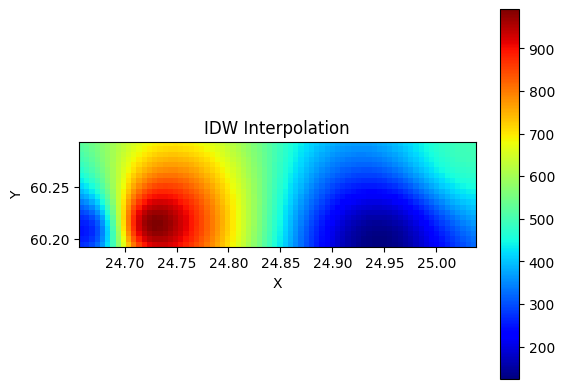

In [4]:
x, y, interpolated_values = idw_interpolation_geodataframe(
    geodataframe=gdf,
    target_column='random_number',
    #output_resolution=(0.00495980000000000032, 0.004826137000000000309),
    output_resolution=(0.005, 0.005),
    extent=(24.6558990000000016, 60.1920590000000004, 25.0378036000000002, 60.2934078769999999),
    #extent=None,
    power=2
)

# Plot the interpolated values
plt.imshow(interpolated_values, cmap='jet', extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('IDW Interpolation')
plt.show()

In [23]:
#  This creates a GeoTiff file in the notebooks folder.

import rasterio

# Specify the output GeoTIFF file path
output_file = '0_005-extent.tif'

# Create a rasterio dataset for writing the GeoTIFF
with rasterio.open(output_file, 'w', driver='GTiff', width=interpolated_values.shape[1],
                   height=interpolated_values.shape[0], count=1, dtype=interpolated_values.dtype,
                   crs=gdf.crs, transform=rasterio.transform.from_origin(x.min(), y.max(), x[1] - x[0], y[1] - y[0])) as dst:
    # Write the interpolated values to the GeoTIFF band
    dst.write(interpolated_values, 1)

print(f"Interpolated values saved as GeoTIFF: {output_file}")

Interpolated values saved as GeoTIFF: 0_005-extent.tif


In [5]:
data = {
        'value1': [1, 2, 3, 4, 5],
        'value2': [5, 4, 3, 2, 1],
        'geometry': [Point(0, 0), Point(1, 1), Point(2, 2), Point(3, 3), Point(4, 4)]
    }
gdf=gpd.GeoDataFrame(data)

[[3.         3.40648594 4.02086331 5.        ]
 [2.59351406 3.         3.77021471 4.02086331]
 [1.97913669 2.22978529 3.         3.40648594]
 [1.         1.97913669 2.59351406 3.        ]]


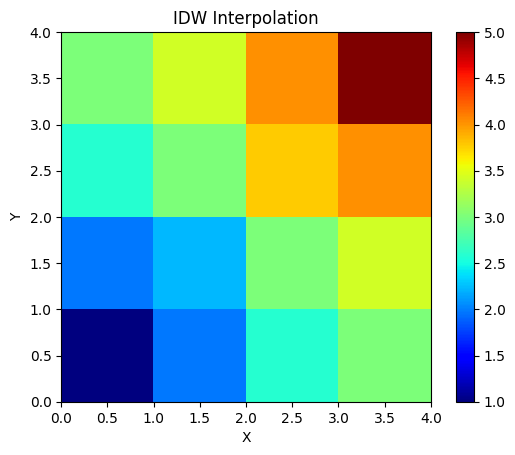

In [6]:
x, y, interpolated_values = idw_interpolation_geodataframe(
    geodataframe=gdf,
    target_column='value1',
    output_resolution=(1, 1),
    extent=None,
    power=2
)
print(interpolated_values)
# Plot the interpolated values
plt.imshow(interpolated_values, cmap='jet', extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('IDW Interpolation')
plt.show()